In [27]:
import pandas as pd
import numpy as np  

%matplotlib inline 

<h3>Load the data file using pandas.</h3>

In [3]:
path = "googleplaystore.csv"
df=pd.read_csv(path)

<h3>Check for null values in the data. Get the number of null values for each column.</h3>

In [4]:
missing_data = df.isnull()


<h4>count missing values in each column</h4>

In [5]:
df.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [6]:
df.shape

(10841, 13)

<h3>Drop records with nulls in any of the columns.</h3>

In [7]:
df.dropna(subset="Rating",axis=0,inplace=True)
df.dropna(subset="Content Rating",axis=0,inplace=True)
df.dropna(subset="Current Ver",axis=0,inplace=True)
df.dropna(subset="Android Ver",axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)

In [8]:
df.shape

(9360, 13)

<h3> Fix Variables with wrong data types</h3>

In [9]:
print(df['Size'])

0                      19M
1                      14M
2                     8.7M
3                      25M
4                     2.8M
               ...        
9355                  2.6M
9356                   53M
9357                  3.6M
9358    Varies with device
9359                   19M
Name: Size, Length: 9360, dtype: object


In [10]:


def convert_size_to_kb(size):
    if 'M' in size:
        return float(size.replace('M', '')) * 1024  # Convert MB to KB
    elif 'k' in size:
        return float(size.replace('k', ''))  # Already in KB
    else:
        return None  # For cases like "Varies with device"

# Apply the function to the 'Size' column
df['Size_KB'] = df['Size'].apply(lambda x: convert_size_to_kb(str(x)))

# Display the updated 'Size' column with the new 'Size_KB' column
print(df[['Size', 'Size_KB']].head())



   Size  Size_KB
0   19M  19456.0
1   14M  14336.0
2  8.7M   8908.8
3   25M  25600.0
4  2.8M   2867.2


In [11]:
mean_size_kb = df['Size_KB'].mean()
df['Size_KB'].fillna(mean_size_kb, inplace=True)

In [12]:
print(df[['Size', 'Size_KB']].sample(10))

                    Size       Size_KB
5020                3.6M   3686.400000
3045                 55M  56320.000000
8018                3.9M   3993.600000
1780                 55M  56320.000000
4374                 45M  46080.000000
8042                 23M  23552.000000
8234                 32M  32768.000000
8309                 65M  66560.000000
3196  Varies with device  23521.402629
4353                2.9M   2969.600000


In [13]:
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

df.dtypes

App                object
Category           object
Rating            float64
Reviews             int64
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
Size_KB           float64
dtype: object

In [14]:
# Remove '+' and ',' from the 'Installs' field, and convert the result to an integer
df['Installs'] = df['Installs'].str.replace('+', '', regex=False)  
df['Installs'] = df['Installs'].str.replace(',', '', regex=False)  
df['Installs'] = df['Installs'].astype(int) 




In [15]:

print(df[['Installs']].sample(10))

      Installs
6882     10000
7439   1000000
592        100
1683  50000000
2216   1000000
6586   5000000
6743     10000
4120    100000
4642     10000
2326      5000


In [16]:
# Remove '$' from the 'Price' field and convert the result to a numeric type
df['Price'] = df['Price'].str.replace('$', '', regex=False) 
df['Price'] = pd.to_numeric(df['Price']) 





In [17]:
print(df[['Price']].sample(10))

      Price
7670   0.00
3877   0.00
5408   1.99
4475   0.00
53     0.00
5440   0.00
2022   0.00
4561   0.00
4832   0.00
6276   0.00


In [18]:
df.dtypes

App                object
Category           object
Rating            float64
Reviews             int64
Size               object
Installs            int32
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
Size_KB           float64
dtype: object

<h3>Sanity check</h3>

<h4>Check Rating between 1 and 5</h4>

In [19]:
# Drop rows where the 'Rating' is outside the range of 1 to 5
df = df[(df['Rating'] >= 1) & (df['Rating'] <= 5)]


print(df[['Rating']].head())


print("Any ratings outside the range 1 to 5?", not df['Rating'].between(1, 5).all())

   Rating
0     4.1
1     3.9
2     4.7
3     4.5
4     4.3
Any ratings outside the range 1 to 5? False


<h4>Reviews should not be more than installs as only those who installed can review the app. If there are any such records, drop them.</h4>

In [20]:
# Convert 'Reviews' to a numeric value, handling cases like '3.0M'
def convert_reviews_to_int(reviews):
    if 'M' in reviews:
        return float(reviews.replace('M', '')) * 1000000
    elif 'k' in reviews:
        return float(reviews.replace('k', '')) * 1000
    else:
        return int(reviews)


df['Reviews'] = df['Reviews'].apply(lambda x: convert_reviews_to_int(str(x)))


df = df[df['Reviews'] <= df['Installs']]





In [21]:
print(df[['Reviews', 'Installs']].sample(15))

      Reviews  Installs
7630    30291   1000000
8002        6      1000
7156       79      1000
3480    11297   1000000
8791      129     50000
6267    10006   1000000
8885   264282  10000000
5246      284     10000
3344   209696   5000000
6211    11187   1000000
4123    19047    100000
2869   521138  10000000
262      2111    100000
2129    66660   5000000
3704    23279   1000000


<h4>Apps of <b>type free</b> price shouldn't be greater than 0.0</h4>

In [24]:
# Filter the dataframe to drop rows where the 'Type' is 'Free' but the 'Price' is greater than 0
df = df[~((df['Type'] == 'Free') & (df['Price'] > 0))]





In [25]:

print(df.sample())

                 App Category  Rating  Reviews Size  Installs  Type  Price  \
7278  Just Dance Now     GAME     4.2   794058  56M  10000000  Free    0.0   

     Content Rating Genres   Last Updated Current Ver Android Ver  Size_KB  
7278       Everyone  Music  June 12, 2018       2.3.0  4.4 and up  57344.0  


In [26]:
df.to_csv('datawrangling.csv')

<h3>Box plot for Price to check outliers</h3>

In [41]:

import seaborn as sns
import matplotlib.pyplot as plt
path = "datawrangling.csv"
df=pd.read_csv(path)

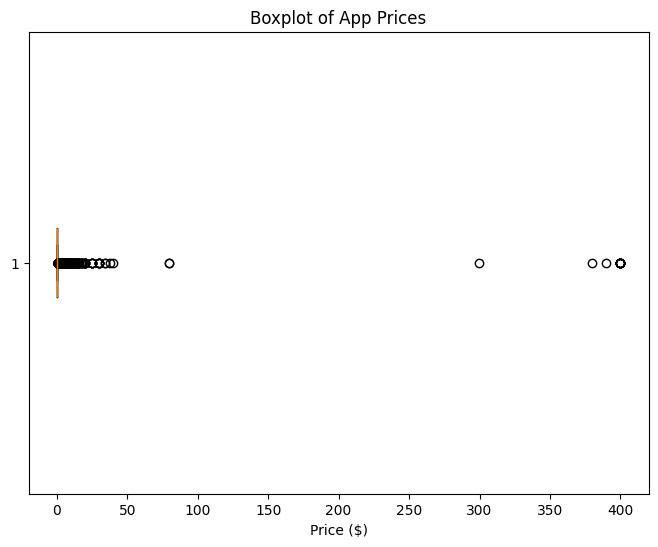

In [42]:
# Create a boxplot for the 'Price' column
plt.figure(figsize=(8, 6))
plt.boxplot(df['Price'], vert=False)
plt.title('Boxplot of App Prices')
plt.xlabel('Price ($)')
plt.show()



<p> App prices has outliers for app prices over 250</p>

<h3>Boxplot to visualize apps with very high number of reviews</h3>

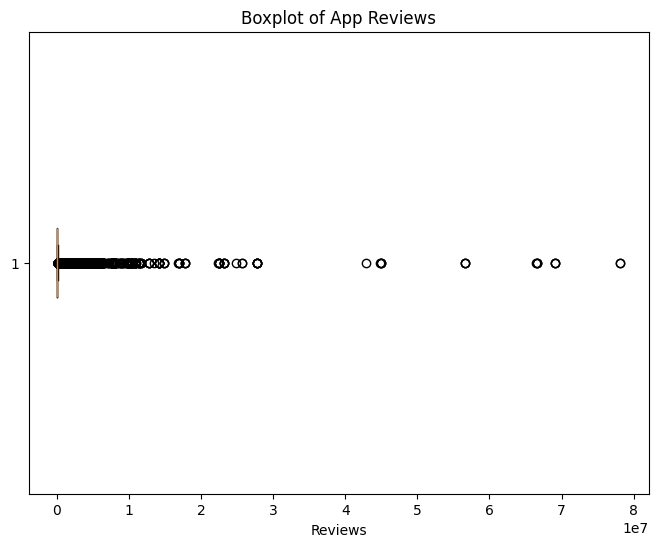

In [43]:
# Create a boxplot for the 'Reviews' column
plt.figure(figsize=(8, 6))
plt.boxplot(df['Reviews'], vert=False)
plt.title('Boxplot of App Reviews')
plt.xlabel('Reviews')
plt.show()


<h4>Histogram for app rating </h4>

C:\Users\khi00\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khi00\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


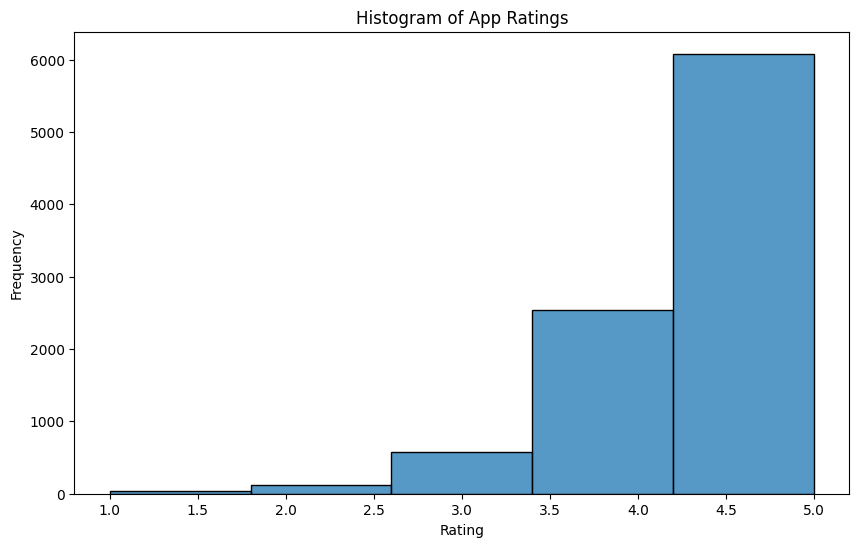

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating'], bins=5, kde=False)
plt.title('Histogram of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

<p>Most apps are rated above 4</p>

<h4>Histogram for Size</h4>

C:\Users\khi00\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khi00\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khi00\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


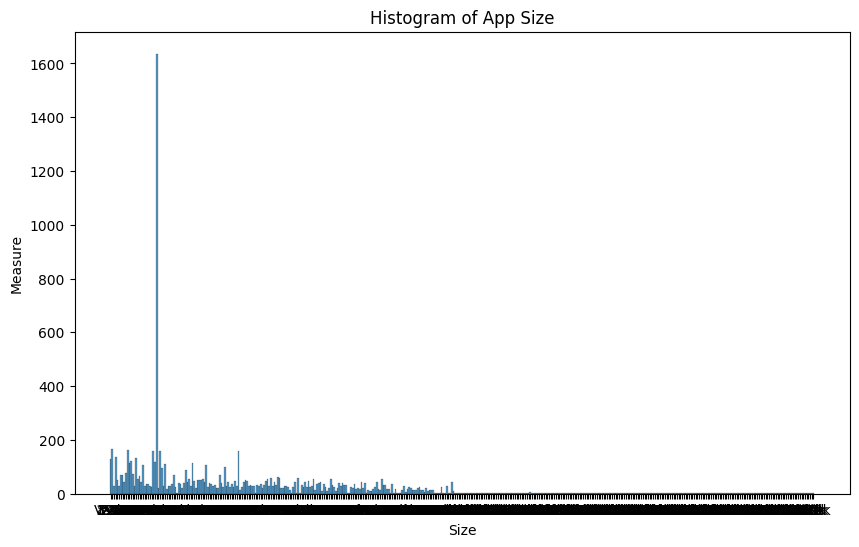

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Size'], bins=5, kde=False)
plt.title('Histogram of App Size')
plt.xlabel('Size')
plt.ylabel('Measure')
plt.show()

In [46]:
df.shape

(9353, 15)

<h4>Dealing with Outliers</h4>

In [47]:
filtered_df = df[~((df['Type'] == 'Free') & (df['Price'] > 0))]

# Identify records with a very high price, e.g., prices greater than or equal to $200
high_price_apps = filtered_df[filtered_df['Price'] >= 200]

# Display these records to review them
print(high_price_apps)



      Unnamed: 0                             App   Category  Rating  Reviews  \
4035        4036          most expensive app (H)     FAMILY     4.3        6   
4188        4189                      💎 I'm rich  LIFESTYLE     3.8      718   
4193        4194        I'm Rich - Trump Edition  LIFESTYLE     3.6      275   
5040        5042                       I am rich  LIFESTYLE     3.8     3547   
5043        5045                  I am Rich Plus     FAMILY     4.0      856   
5044        5046                   I am rich VIP  LIFESTYLE     3.8      411   
5045        5047               I Am Rich Premium    FINANCE     4.1     1867   
5046        5048             I am extremely Rich  LIFESTYLE     2.9       41   
5047        5049                      I am Rich!    FINANCE     3.8       93   
5048        5050              I am rich(premium)    FINANCE     3.5      472   
5051        5053                   I Am Rich Pro     FAMILY     4.4      201   
5053        5055  I am rich (Most expens

In [48]:
filtered_df = filtered_df[filtered_df['Price'] < 200]

In [49]:
df = filtered_df.query('Reviews <= 2000000')
print(df["Reviews"])

0          159
1          967
2        87510
3       215644
4          967
         ...  
9348         7
9349        38
9350         4
9351       114
9352    398307
Name: Reviews, Length: 8885, dtype: int64


In [50]:
# Calculate the percentiles for the "Installs" column
percentiles = df['Installs'].quantile([0.10, 0.25, 0.50, 0.70, 0.90, 0.95, 0.99])

print("Percentiles for 'Installs':")
print(percentiles)

Percentiles for 'Installs':
0.10         1000.0
0.25        10000.0
0.50       500000.0
0.70      1000000.0
0.90     10000000.0
0.95     10000000.0
0.99    100000000.0
Name: Installs, dtype: float64


In [51]:
cutoff_threshold = percentiles[0.70]

In [52]:
df_filtered = df[df['Installs'] <= cutoff_threshold]


print(df)

      Unnamed: 0                                                App  \
0              0     Photo Editor & Candy Camera & Grid & ScrapBook   
1              1                                Coloring book moana   
2              2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3              3                              Sketch - Draw & Paint   
4              4              Pixel Draw - Number Art Coloring Book   
...          ...                                                ...   
9348        9355                                      FR Calculator   
9349        9356                                   Sya9a Maroc - FR   
9350        9357                   Fr. Mike Schmitz Audio Teachings   
9351        9358                      The SCP Foundation DB fr nn5n   
9352        9359      iHoroscope - 2018 Daily Horoscope & Astrology   

                 Category  Rating  Reviews                Size  Installs  \
0          ART_AND_DESIGN     4.1      159                 19M     1000

In [53]:
#save a copy of Outlier treatment
df.to_csv('outlierTreatment.csv')

<h2>Bivariate analysis:</h2>

In [74]:

import seaborn as sns
import matplotlib.pyplot as plt

path = "outlierTreatment.csv"
df=pd.read_csv(path)

<h3>scatter plot/joinplot for Rating vs. Price</h3>

C:\Users\khi00\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khi00\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


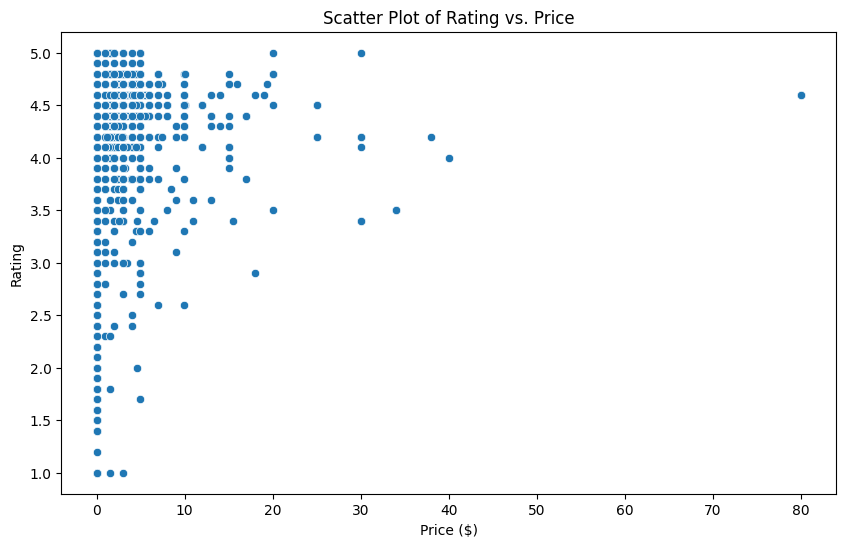

In [75]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='Rating', data=df)
plt.title('Scatter Plot of Rating vs. Price')
plt.xlabel('Price ($)')
plt.ylabel('Rating')
plt.show()

<p>The weak positive correlation means that Rating and Price don’t have much of a linear relationship. In simple terms, changes in Price barely affect Rating, if at all.</p>The weak positive correlation means that Rating and Price don’t have much of a linear relationship. In simple terms, changes in Price barely affect Rating, if at all.

<h3>

 scatter plot/joinplot for Rating vs. Size

</h3>

In [76]:
df[['Rating','Size_KB']].corr()

,Rating,Size_KB
Rating,1.000000,0.064489
Size_KB,0.064489,1.000000


<p>The correlation of -0.022181 indicates that Rating and Size are almost uncorrelated, with a very weak negative relationship. In practical terms, changes in Size have little to no effect on Rating.</p>

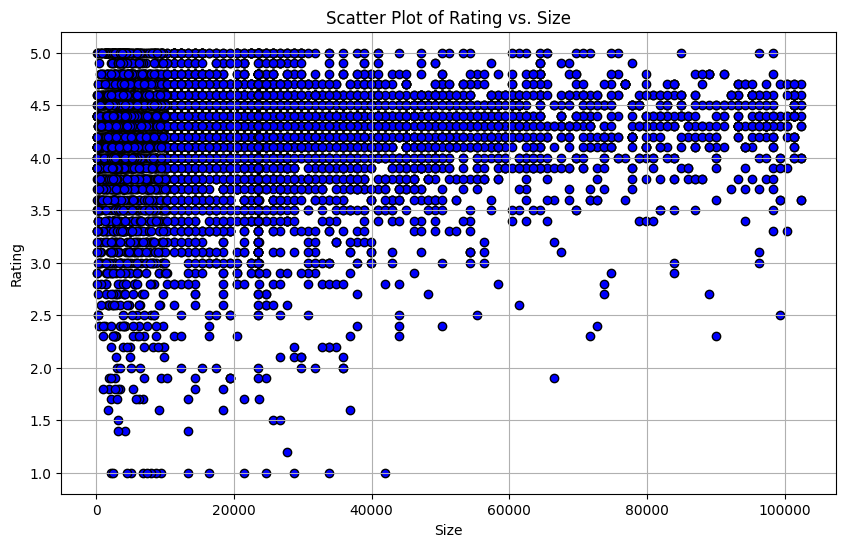

In [77]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Size_KB'], df['Rating'], color='blue', edgecolor='black')
plt.title('Scatter Plot of Rating vs. Size')
plt.xlabel('Size')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


<h3> scatter plot/joinplot for Rating vs. Reviews</h3>

In [78]:
df[['Rating','Reviews']].corr()

,Rating,Reviews
Rating,1.000000,0.148101
Reviews,0.148101,1.000000


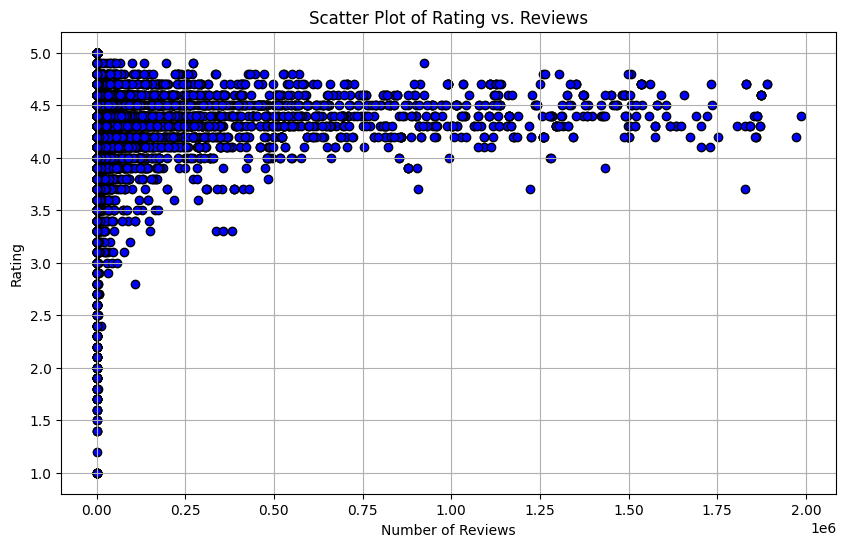

In [79]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Reviews'], df['Rating'], color='blue', edgecolor='black')
plt.title('Scatter Plot of Rating vs. Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

<p>The weak positive correlation (0.143) suggests a small, but not strong, positive relationship between Rating and Reviews.</p>

<h3>boxplot for Ratings vs. Content Rating</h3>

C:\Users\khi00\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khi00\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khi00\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


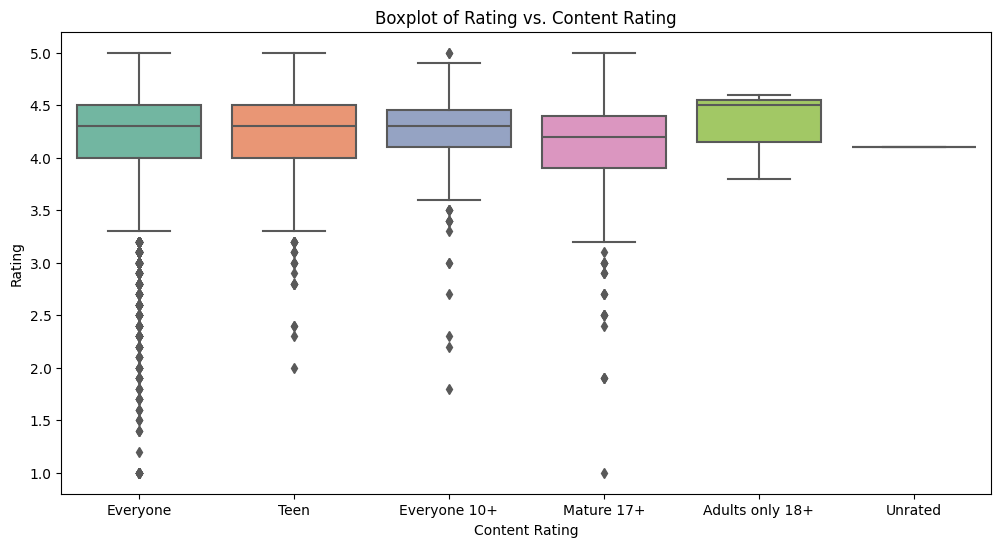

In [80]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Content Rating', y='Rating', data=df, palette='Set2')

plt.title('Boxplot of Rating vs. Content Rating')
plt.xlabel('Content Rating')
plt.ylabel('Rating')
plt.show()

<h3>boxplot for Ratings vs. Category</h3>

In [81]:
categories = df['Category'].unique()
print(categories)

['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION']


C:\Users\khi00\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khi00\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khi00\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


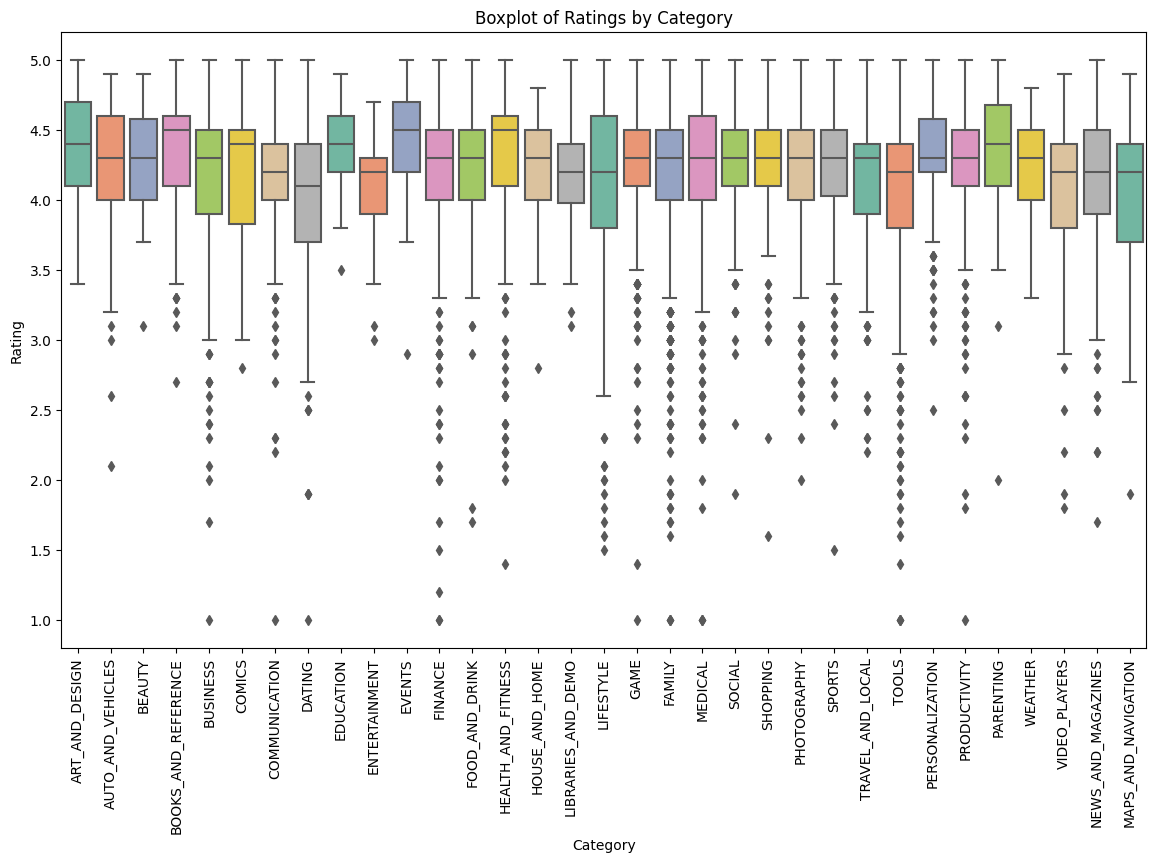

In [82]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Category', y='Rating', data=df, palette='Set2')

plt.title('Boxplot of Ratings by Category')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.xticks(rotation=90)  # Rotate category labels for better readability
plt.show()

In [83]:

df.to_csv('Bivariant_analysis.csv')

<h2>data prepocessing</h2>

In [18]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
path = "Bivariant_analysis.csv"
df=pd.read_csv(path)

In [19]:
# Create a copy of the dataframe 
inp1 = df.copy()





In [20]:
# Apply log transformation to 'Reviews' and 'Installs' to reduce the skewness
inp1['Reviews'] = inp1['Reviews'].apply(pd.to_numeric, errors='coerce')
inp1['Installs'] = inp1['Installs'].apply(pd.to_numeric, errors='coerce')


In [21]:
inp1['Reviews_log'] = inp1['Reviews'].apply(lambda x: np.log1p(x) if pd.notnull(x) else x)
inp1['Installs_log'] = inp1['Installs'].apply(lambda x: np.log1p(x) if pd.notnull(x) else x)

In [22]:
print(inp1.head())

   Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0             0             0           0   
1             1             1           1   
2             2             2           2   
3             3             3           3   
4             4             4           4   

                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

   Reviews  Size  Installs  Type  Price Content Rating  \
0      159   19M     10000  Free    0.0       Everyone   
1      967   14M    500000  Free    0.0       Everyone   
2    87510  8.7M   5000000  Free    0.0       Everyone   
3   215644   25M

In [23]:
# Drop columns that are needed in this task
columns_to_drop = ['App', 'Last Updated', 'Current Ver', 'Android Ver','Size']
inp1 = inp1.drop(columns=columns_to_drop)



In [24]:
inp1.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,Size_KB,Reviews_log,Installs_log
0,0,0,0,ART_AND_DESIGN,4.1,159,10000,Free,0.0,Everyone,Art & Design,19456.0,5.075174,9.210440
1,1,1,1,ART_AND_DESIGN,3.9,967,500000,Free,0.0,Everyone,Art & Design;Pretend Play,14336.0,6.875232,13.122365
2,2,2,2,ART_AND_DESIGN,4.7,87510,5000000,Free,0.0,Everyone,Art & Design,8908.8,11.379520,15.424949
3,3,3,3,ART_AND_DESIGN,4.5,215644,50000000,Free,0.0,Teen,Art & Design,25600.0,12.281389,17.727534
4,4,4,4,ART_AND_DESIGN,4.3,967,100000,Free,0.0,Everyone,Art & Design;Creativity,2867.2,6.875232,11.512935


In [32]:
# Create dummy columns for 'Category', 'Genres', and 'Content Rating'
inp2 = pd.get_dummies(inp1, columns=['Category', 'Genres', 'Content Rating','Type'])

inp2.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Rating,Reviews,Installs,Price,Size_KB,Reviews_log,Installs_log,...,Genres_Weather,Genres_Word,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated,Type_Free,Type_Paid
0,0,0,0,4.1,159,10000,0.0,19456.0,5.075174,9.210440,...,False,False,False,True,False,False,False,False,True,False
1,1,1,1,3.9,967,500000,0.0,14336.0,6.875232,13.122365,...,False,False,False,True,False,False,False,False,True,False
2,2,2,2,4.7,87510,5000000,0.0,8908.8,11.379520,15.424949,...,False,False,False,True,False,False,False,False,True,False
3,3,3,3,4.5,215644,50000000,0.0,25600.0,12.281389,17.727534,...,False,False,False,False,False,False,True,False,True,False
4,4,4,4,4.3,967,100000,0.0,2867.2,6.875232,11.512935,...,False,False,False,True,False,False,False,False,True,False


<h3> Train test split  and apply 70-30 split</h3>


In [41]:
from sklearn.metrics import  mean_squared_error

In [33]:
# Perform a 70-30 train-test split
df_train, df_test = train_test_split(inp2, test_size=0.3, random_state=42)



In [34]:
# Display the first few rows of the train and test dataframes
print("Train DataFrame:")
print(df_train.head())

print("\nTest DataFrame:")
print(df_test.head())

Train DataFrame:
      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  Rating  Reviews  Installs  \
5614          5614          6054        6057     3.0       69     10000   
6114          6114          6555        6559     4.1      315     10000   
5129          5129          5560        5563     4.4      172      5000   
2300          2300          2519        2520     4.4   441473  10000000   
5498          5498          5934        5937     4.7     6073    100000   

      Price       Size_KB  Reviews_log  Installs_log  ...  Genres_Weather  \
5614   0.00  31744.000000     4.248495      9.210440  ...           False   
6114   0.00   7884.800000     5.755742      9.210440  ...           False   
5129   2.99  50176.000000     5.153292      8.517393  ...           False   
2300   0.00  23521.402629    12.997874     16.118096  ...           False   
5498   0.00   8704.000000     8.711773     11.512935  ...           False   

      Genres_Word  Content Rating_Adults only 18+  Content Rating_Eve

<h4>Model Building</h4>

In [36]:
X_train = df_train.drop(columns=['Rating'])
y_train = df_train['Rating']


In [37]:
model = LinearRegression()

In [38]:
model.fit(X_train, y_train)

LinearRegression()

In [39]:
y_train_pred = model.predict(X_train)

In [42]:
r2_train = r2_score(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

In [43]:
print(f'R² on the train set: {r2_train:.4f}')
print(f'RMSE on the train set: {rmse_train:.4f}')

R² on the train set: 0.1674
RMSE on the train set: 0.4746


<p> R² of 0.1674 and an RMSE of 0.4746 which mean that the model is not capture replationships with linear model </p>

In [48]:
# 7. Analyze coefficients (feature importance)
coefficients = pd.Series(model.coef_, index=X_train.columns)
print("Coefficients of the linear model:")
print(coefficients.sort_values(ascending=False))

Coefficients of the linear model:
Genres_Board;Pretend Play                     0.560976
Genres_Strategy;Education                     0.542386
Genres_Educational;Brain Games                0.472970
Genres_Music;Music & Video                    0.472686
Genres_Entertainment;Creativity               0.332106
                                                ...   
Genres_Parenting;Education                   -0.305105
Genres_Video Players & Editors;Creativity    -0.309463
Genres_Entertainment;Pretend Play            -0.342128
Genres_Trivia                                -0.375453
Genres_Health & Fitness;Action & Adventure   -0.418052
Length: 165, dtype: float64


In [49]:
# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = rf_model.predict(X_train)

# Evaluate the model on the training set
r2_train_rf = r2_score(y_train, y_train_pred)
rmse_train_rf = mean_squared_error(y_train, y_train_pred, squared=False)

print(f'R² on the train set: {r2_train_rf:.4f}')
print(f'RMSE on the train set: {rmse_train_rf:.4f}')

R² on the train set: 0.8793
RMSE on the train set: 0.1807


<p>R² on the train set: 0.8793
RMSE on the train set: 0.1807 the model successfully fits
</p>

<p>to estimate how accurately a predictive model will perform in practice cross-validation is used</p>

<p>We fit 5 folds to see performmance and after that make average prediction</p>

In [57]:
# Separate features and target variable in the test set
X_test = df_test.drop(columns=['Rating'])
y_test = df_test['Rating']

# use the best model for prediction
y_test_pred = best_rf_model.predict(X_test)

# Test the model
r2_test = r2_score(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print(f'R² on the test set: {r2_test:.4f}')
print(f'RMSE on the test set: {rmse_test:.4f}')

R² on the test set: 0.1914
RMSE on the test set: 0.4791


In [67]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = xgb_model.predict(X_test)

# Evaluate the model on the test set
r2_test_xgb = r2_score(y_test, y_test_pred)
rmse_test_xgb = mean_squared_error(y_test, y_test_pred, squared=False)

print(f'R² on the test set: {r2_test_xgb:.4f}')
print(f'RMSE on the test set: {rmse_test_xgb:.4f}')



R² on the test set: 0.1432
RMSE on the test set: 0.4932


In [66]:
!pip install xgboost
